# Ideal training loop 

In [ ]:
import torch
import torchvision

# define config 

epoch = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_seed = 1
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
hinge_loss = torch.nn.NLLLoss()



```
So, basically loss is one-element PyTorch tensor
and .item() converts its value to a standard Python number.
```





```
Note that in this paper, "small batch" is defined as 256 samples which is 
already pretty large in some cases :) and "large batch" is 10% of the dataset
~ jakis random z neta sprawdzic to
```





```
The batch size determines how many training examples are processed in parallel
 for training/inference. The batch size at training time can affect how fast 
 and how well your training converges. You can find a discussion of this effect 
 here. Thus, for train_batch_size, it's worth picking a batch size that is 
 neither too small nor too large (as discussed in the previously linked 
 discussion). For some applications, using the largest possible training 
 batches can actually be desirable, but in general, you select it through 
 experiments and validation.

However, for validation_batch_size and test_batch_size, you should pick the 
largest batch size that your hardware can handle without running out of memory 
and crashing. Finding this is usually a simple trial and error process. The 
larger your batch size at inference time, the faster it will be, since more 
inputs can be processed in parallel.
```





1.   CUDA gpu/cpu ✅
2.   Early stopping ✅
3.   Log interval ✅ ! Poprawic TQDM
4.   TQDM ✅
5.   Scheduler + start epoch ✅
6.   Visualization ✅
7.   batch size max (ogarnac quantization oraz gpu/cpu kiedy warto max dac) ❌
8.   Time of epoch i podsumowanie jak w tensorflow bylo train test itd ✅
9.   Plotowanie w loss nie co epoke tylko co pol albo 100 przykladow albo cos innego wymyslic ✅
10.  Confusion Matrix ✅
11.  Dummy classifier ile bedzie mial (z uwzglednieniem niezbalansowania datasetu ale to chyba na jedno wyjdzie) ✅ 
12. save best ✅ 
13. Accuracy ✅
14. EDA bad examples plot ❌
15. model checkpoint jak w keras np. save co 5 epok i save tylko wagi / caly model ❌
16. BackupAndRestore jesli sie wywali w treningu z jakiegos powodu to pusc epoke od nowa ❌
17. Weights and biases podlaczyc / tensorboard albo cos podobnego ❌
18. RemoteMonitor stramuje trening na serwer to mozna W&B ❌
19. TerminateOnNaN jesli bedzie vanish albo explode gradient to stop ❌
20. CSVLogger zapisz trening do csv pandas dataframe zrobic ✅
21. Ideas from [W&B Article](https://wandb.ai/wandb_fc/tips/reports/How-to-Write-Efficient-Training-Loops-in-PyTorch--VmlldzoyMjg4OTk5) e.g. gradient accumulation ❌


* zrobic funkcje ktora bierze rand tensor (b_size, chann, size, size) i znajduje max b_size, trzeba wziac pod uwage ze pamiec tez ma na sobie wagi sieci itd podczas treningu a wtej funkcji nie ! 

In [ ]:
class EarlyStopping():
    '''
    Method for avoid ofervitting by stopping when test loss doesn't decrease

    '''
    def __init__(self, old_loss=float('inf'), patience=5, delta=0.001, mode="simple", save=False):
        '''
        Attributes
        ---------------------

        old_loss: float
            ON START IS EQUAL TO PLUS INFINITY
            loss from last epoch
            On metric you can use test loss, acc or your own idea

        patience: int
            number of epochs to check until break training
        
        delta: float
            A minimum increase in the score to qualify as an improvement,
            i.e. an increase of less than or equal to min_delta,
            will count as no improvement.
        
        mode: str
            if 'simple' model stop train when loss doesn't decrease 
            patience time.

        save: bool
            If True Saves best model every epoch
            if epoch before was better don't overwrite
            SAVE MODEL WITH SHAPE NOT ONLY WEIGHTS

        Parameters
        --------------------
        counter: int 0 
            If counter reach patience stop training
        
        best_loss: float
            save best weights
        '''
        self.old_loss = old_loss
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.save = save
        self.counter = 0
        self.best_loss = float('inf')

    def run(self, new_loss, model=None):
        '''
        Attributes
        ------------------------
        model: (check)
            model to save weights
        new_loss: float
            new loss after test

        Returns
        -------------------
        bool:
            True if training should stop
        
        best model parameters or saved file 
        '''
        if new_loss < self.old_loss:
            if (self.old_loss - new_loss) <= self.delta:
                self.counter += 1 
            else:
                # jesli sie zmiejszyl o wiecej niz delta to wyzeruj counter
                self.counter = 0
            self.old_loss = new_loss
        elif new_loss > self.old_loss:
            # dodaj do countera
            self.counter += 1
        
        # save best model
        if self.save is True:
            if new_loss <= self.best_loss: # tutaj pomiesane bo nie zapisze po 1 razie tylko po kolejnych
                #print("nowy loss mniejszy niz stary wiec nadpisuje best")
                self.best_loss = new_loss
                #print(f"ZAPISUJE MODEL Z TEST LOSS: {self.best_loss}")
                torch.save(model, 'best_model.pth')
                

        # stop training
        if self.counter >= self.patience:
            return True
        
        return False



In [ ]:
from tqdm import tqdm
import numpy as np
import time

# CUDA automatyczne wykrywanie dodac
# log intervals+

def calculate_log_interval(dataloader, percent=10):
    '''
    Attributes
    --------------------------
    if percent == 10, log will be printed every 10% of dataset

    no nie do konca takto bedzie dzialac xd
    '''
    num_batches = len(dataloader)
    p = lambda x : x/100
    calc_per = p(percent)
    result = int(num_batches*calc_per)
    print(f"Number of batches in dataset: {num_batches}, for percent: {percent}, log_interval is: {result}")
    return result


def train_function(model, loss_fn, optimizer, dataloader, log_interval=None):
    '''
    Function for training one epoch in model

    Parameters
    -------------------------------
    epoch : int
        Number of epochs to train the model
    
    model : (sprawdzic)
        Neural network model to train

    loss_fn : (check)
        Function which compute loss
    
    optimizer : (check)
        Optimizer adjust learnable parameters
    
    dataloader : (torch.utils..)
        TRAIN dataloader

    log_interval: int
        if 10 log interval wiill be printed every 10 batches

    Attributes
    ------------------------------
    X, y : torch.Tensor
        data and label (n_samples, in_channels, img_size, img_size)
    
    loss : (check)
        computed loss

    Returns
    -----------------------
    logits : torch.Tensor
        Logits over all the classes - '(n_smaples, n_classes)'
    '''
    interval_loss = []
    model.train()
    train_loss = 0.
    num_batches = len(dataloader)
    #log_interval = int((len(dataloader.dataset) % log_interval))
    for i, (data, label) in tqdm(enumerate(dataloader), position=0, leave=True, total=len(dataloader)):
        data = data.to(device)
        label = label.to(device)
        # 1. clear gradients
        model.zero_grad()

        # 2. forward pass
        label_pred = model(data)

        # 3. compute loss
        loss = loss_fn(label_pred, label)

        # 4. compute gradients
        loss.backward()

        # 5. adjust learnable parameters
        optimizer.step()

        train_loss += loss.item()
        if log_interval is not None:
            if i % log_interval == 0:
                tqdm.write(f"For batch: 0-{i+1} train_loss: {train_loss/(i+1)}")
                interval_loss.append(train_loss/(i+1))
            
    train_loss /= num_batches
    return train_loss, interval_loss
    


def test_function(model, loss_fn, dataloader):
    '''
    Test one epoch in model
    Function for training one epoch in model

    Parameters
    -------------------------------
    model : (sprawdzic)
        Neural network model to train

    loss_fn : (check)
        Function which compute loss
    
    dataloader : (torch.utils..)
        TEST dataloader
    

    Attributes
    ------------------------------
    X, y : torch.Tensor
        data and label (n_samples, in_channels, img_size, img_size)
    
    loss : (check)
        computed loss

    Returns
    -----------------------
    logits : torch.Tensor
        Logits over all the classes - '(n_smaples, n_classes)'
    '''
    model.eval()
    correct = 0.
    test_loss = 0.
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    with torch.no_grad():
        for data, label in tqdm(dataloader, position=0, leave=True):
            data = data.to(device)
            label = label.to(device)
            preds = model(data)
            correct += (preds.argmax(1) == label).type(torch.float).sum().item()
            test_loss += loss_fn(preds, label).item()
    test_loss /= num_batches
    accuracy = correct/size
    return test_loss, accuracy


def train_model(epoch: int, model, loss_fn, optimizer, train_dataloader, test_dataloader, scheduler=None, start_epoch=0, log_interval=None, patience=3):
    '''
    Attributes
    ---------------------
    log interval: int
        if 10 log interval wiill be printed every 10% of dataset
    '''
    if scheduler is not None:
        for i in range(0, start_epoch): # po co ? bo dziala od ktorejs epoki czasami !!!
            scheduler.step()
    
    all_interval_losses = [] # nie np array poniewaz roznie to moze wychodzic z iloscia batch
    stop_training = EarlyStopping(patience=patience, save=True)
    base_loss = test_function(model, loss_fn, test_dataloader) # check loss without training
    train_loss = np.zeros(epoch)
    test_loss = np.zeros(epoch)
    acc_tab = np.zeros(epoch)
    for i in range(epoch):
        start_time = time.time()
        train_loss[i], interval_loss = train_function(model, loss_fn, optimizer, train_dataloader, log_interval)
        t_train = time.time() - start_time
        test_loss[i], acc_tab[i] = test_function(model, loss_fn, test_dataloader)
        t_test = time.time() - t_train - start_time

        all_interval_losses.append(interval_loss)
        if scheduler is not None:
            scheduler.step()

        print(f"EPOCH: {i+1},  TRAIN LOSS: {round(train_loss[i],5)}, TEST LOSS: {round(test_loss[i],5)}, ACCURACY: {acc_tab[i]} TRAIN/TEST TIME: {round(t_train, 3)}/{round(t_test, 3)} sec \n")
        decision = stop_training.run(test_loss[i], model)

        if decision == True:
            print("TRAINING STOP")
            # remove 0s from array
            train_loss = np.trim_zeros(train_loss, 'b')
            test_loss = np.trim_zeros(test_loss, 'b')
            acc_tab = np.trim_zeros(acc_tab, 'b')
            break
            
    return train_loss, test_loss, acc_tab, base_loss, all_interval_losses

xd = calculate_log_interval(train_loader, percent=10)

Number of batches in dataset: 938, for percent: 10, log_interval is: 93


In [ ]:
import pandas as pd

def create_csv(train_loss, test_loss, acc_tab):
    '''
    Save logs to csv
    '''
    df = pd.DataFrame((train_loss, test_loss, acc_tab), columns=['Train Loss', 'Test Loss', 'Accuracy'])
    df.to_csv("Training logs")
    

In [ ]:
import torch.optim.lr_scheduler

epoch=50
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum) # zapomniale o tym dlatego loss sie nie zmniejszal
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

train_loss, test_loss, acc_tab, base_loss, all_interval_losses = train_model(epoch, network, hinge_loss,
                                                                             optimizer, train_loader, test_loader, scheduler, start_epoch=0, log_interval=93, patience=3)

  1%|          | 5/938 [00:00<00:40, 22.99it/s]

For batch: 0-1 train_loss: 2.3355517387390137


 10%|█         | 98/938 [00:03<00:34, 24.13it/s]

For batch: 0-94 train_loss: 2.250664957026218


 20%|██        | 191/938 [00:07<00:28, 26.41it/s]

For batch: 0-187 train_loss: 2.014592251038169


 30%|███       | 283/938 [00:11<00:25, 26.00it/s]

For batch: 0-280 train_loss: 1.7244292565754482


 40%|████      | 376/938 [00:15<00:23, 24.23it/s]

For batch: 0-373 train_loss: 1.5133290442640597


 50%|█████     | 469/938 [00:18<00:17, 27.33it/s]

For batch: 0-466 train_loss: 1.3598954932116643


 60%|█████▉    | 562/938 [00:21<00:13, 27.99it/s]

For batch: 0-559 train_loss: 1.2457150615925012


 70%|██████▉   | 655/938 [00:25<00:10, 26.89it/s]

For batch: 0-652 train_loss: 1.151970298926523


 80%|███████▉  | 748/938 [00:28<00:06, 28.04it/s]

For batch: 0-745 train_loss: 1.0802486818108783


 90%|████████▉ | 841/938 [00:31<00:03, 26.19it/s]

For batch: 0-838 train_loss: 1.017558916443003


100%|█████████▉| 935/938 [00:35<00:00, 23.55it/s]

For batch: 0-931 train_loss: 0.9661555070305997


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


EPOCH: 1,  TRAIN LOSS: 0.96266, TEST LOSS: 0.1939, ACCURACY: 0.9438 TRAIN/TEST TIME: 35.627/3.287 sec 



  0%|          | 3/938 [00:00<00:38, 24.58it/s]

For batch: 0-1 train_loss: 0.5186507701873779


 11%|█         | 99/938 [00:03<00:29, 28.40it/s]

For batch: 0-94 train_loss: 0.45192952469942416


 20%|██        | 192/938 [00:06<00:27, 27.22it/s]

For batch: 0-187 train_loss: 0.44941287396107127


 30%|███       | 284/938 [00:10<00:27, 23.77it/s]

For batch: 0-280 train_loss: 0.4440257612615824


 40%|████      | 376/938 [00:13<00:20, 27.85it/s]

For batch: 0-373 train_loss: 0.43306868980781005


 50%|█████     | 471/938 [00:16<00:17, 27.35it/s]

For batch: 0-466 train_loss: 0.424398243443265


 60%|██████    | 563/938 [00:20<00:13, 27.55it/s]

For batch: 0-559 train_loss: 0.4155051449783586


 70%|██████▉   | 655/938 [00:23<00:11, 24.52it/s]

For batch: 0-652 train_loss: 0.4120069094390774


 80%|███████▉  | 748/938 [00:27<00:07, 25.35it/s]

For batch: 0-745 train_loss: 0.40668770109847086


 90%|████████▉ | 841/938 [00:30<00:03, 26.92it/s]

For batch: 0-838 train_loss: 0.398407729853807


100%|█████████▉| 934/938 [00:34<00:00, 27.15it/s]

For batch: 0-931 train_loss: 0.3938817377777412


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


EPOCH: 2,  TRAIN LOSS: 0.39362, TEST LOSS: 0.1222, ACCURACY: 0.9636 TRAIN/TEST TIME: 34.332/2.999 sec 



  0%|          | 3/938 [00:00<00:37, 24.67it/s]

For batch: 0-1 train_loss: 0.2988179624080658


 11%|█         | 99/938 [00:03<00:31, 26.99it/s]

For batch: 0-94 train_loss: 0.32863378112620495


 20%|██        | 191/938 [00:06<00:27, 27.52it/s]

For batch: 0-187 train_loss: 0.3248923675102346


 30%|███       | 284/938 [00:10<00:25, 25.61it/s]

For batch: 0-280 train_loss: 0.317553477574672


 40%|████      | 377/938 [00:14<00:23, 23.85it/s]

For batch: 0-373 train_loss: 0.3195571221870647


 50%|█████     | 469/938 [00:17<00:17, 26.99it/s]

For batch: 0-466 train_loss: 0.3141249758171421


 60%|█████▉    | 562/938 [00:21<00:13, 27.95it/s]

For batch: 0-559 train_loss: 0.3126651559938045


 70%|██████▉   | 655/938 [00:24<00:11, 25.13it/s]

For batch: 0-652 train_loss: 0.3117360098436018


 80%|███████▉  | 747/938 [00:28<00:08, 23.30it/s]

For batch: 0-745 train_loss: 0.30896634370488607


 90%|████████▉ | 843/938 [00:31<00:03, 28.59it/s]

For batch: 0-838 train_loss: 0.30736731983241145


100%|█████████▉| 934/938 [00:34<00:00, 28.22it/s]

For batch: 0-931 train_loss: 0.3053121868316904


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


EPOCH: 3,  TRAIN LOSS: 0.30458, TEST LOSS: 0.09655, ACCURACY: 0.9705 TRAIN/TEST TIME: 35.144/2.981 sec 



  0%|          | 3/938 [00:00<00:41, 22.28it/s]

For batch: 0-1 train_loss: 0.29050585627555847


 10%|█         | 97/938 [00:03<00:31, 26.80it/s]

For batch: 0-94 train_loss: 0.2911169474667057


 20%|██        | 190/938 [00:06<00:27, 27.28it/s]

For batch: 0-187 train_loss: 0.2919163570644703


 30%|███       | 284/938 [00:10<00:25, 25.73it/s]

For batch: 0-280 train_loss: 0.2802094290432121


 40%|███▉      | 375/938 [00:13<00:22, 25.03it/s]

For batch: 0-373 train_loss: 0.2775186071866479


 50%|█████     | 469/938 [00:18<00:16, 27.79it/s]

For batch: 0-466 train_loss: 0.2733035377054895


 60%|██████    | 564/938 [00:21<00:13, 27.51it/s]

For batch: 0-559 train_loss: 0.27374136644500524


 70%|██████▉   | 656/938 [00:24<00:10, 26.57it/s]

For batch: 0-652 train_loss: 0.27083634901106174


 80%|███████▉  | 748/938 [00:28<00:07, 27.08it/s]

For batch: 0-745 train_loss: 0.26941561451394286


 90%|████████▉ | 842/938 [00:31<00:03, 26.75it/s]

For batch: 0-838 train_loss: 0.2670624146598051


100%|█████████▉| 934/938 [00:34<00:00, 27.45it/s]

For batch: 0-931 train_loss: 0.2672917748912449


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


EPOCH: 4,  TRAIN LOSS: 0.26691, TEST LOSS: 0.09019, ACCURACY: 0.9736 TRAIN/TEST TIME: 34.926/3.106 sec 



  0%|          | 2/938 [00:00<00:48, 19.22it/s]

For batch: 0-1 train_loss: 0.10219341516494751


 10%|█         | 98/938 [00:03<00:31, 26.32it/s]

For batch: 0-94 train_loss: 0.2445112145803076


 20%|██        | 190/938 [00:06<00:26, 28.03it/s]

For batch: 0-187 train_loss: 0.2287800149484114


 30%|███       | 284/938 [00:10<00:23, 27.41it/s]

For batch: 0-280 train_loss: 0.23454513672207083


 40%|████      | 376/938 [00:13<00:20, 27.22it/s]

For batch: 0-373 train_loss: 0.23633606208553262


 50%|█████     | 471/938 [00:16<00:17, 26.91it/s]

For batch: 0-466 train_loss: 0.23646554304486692


 60%|██████    | 563/938 [00:20<00:13, 27.06it/s]

For batch: 0-559 train_loss: 0.2349806072353677


 70%|███████   | 657/938 [00:23<00:11, 25.04it/s]

For batch: 0-652 train_loss: 0.2368175635240012


 80%|███████▉  | 748/938 [00:26<00:08, 23.34it/s]

For batch: 0-745 train_loss: 0.23725235407184433


 90%|████████▉ | 842/938 [00:30<00:03, 25.51it/s]

For batch: 0-838 train_loss: 0.23639145487728294


100%|█████████▉| 934/938 [00:33<00:00, 26.53it/s]

For batch: 0-931 train_loss: 0.23604415220665625


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


EPOCH: 5,  TRAIN LOSS: 0.23597, TEST LOSS: 0.07673, ACCURACY: 0.9771 TRAIN/TEST TIME: 33.755/3.077 sec 



  0%|          | 2/938 [00:00<00:48, 19.43it/s]

For batch: 0-1 train_loss: 0.061629798263311386


 10%|█         | 98/938 [00:03<00:31, 27.09it/s]

For batch: 0-94 train_loss: 0.20194734613153528


 20%|██        | 190/938 [00:06<00:26, 27.98it/s]

For batch: 0-187 train_loss: 0.21207356717895698


 30%|███       | 283/938 [00:10<00:25, 26.08it/s]

For batch: 0-280 train_loss: 0.22126265302566545


 40%|███▉      | 375/938 [00:13<00:21, 26.49it/s]

For batch: 0-373 train_loss: 0.21909615041902814


 50%|█████     | 470/938 [00:16<00:17, 27.38it/s]

For batch: 0-466 train_loss: 0.22000548567287145


 60%|█████▉    | 562/938 [00:20<00:13, 27.78it/s]

For batch: 0-559 train_loss: 0.21912757293962623


 70%|██████▉   | 655/938 [00:23<00:10, 27.38it/s]

For batch: 0-652 train_loss: 0.21716128297698645


 80%|███████▉  | 749/938 [00:26<00:06, 27.16it/s]

For batch: 0-745 train_loss: 0.21795938085989663


 90%|████████▉ | 842/938 [00:30<00:03, 26.58it/s]

For batch: 0-838 train_loss: 0.21701574605625115


100%|█████████▉| 935/938 [00:33<00:00, 27.55it/s]

For batch: 0-931 train_loss: 0.21632235500037222


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


EPOCH: 6,  TRAIN LOSS: 0.2163, TEST LOSS: 0.07176, ACCURACY: 0.9776 TRAIN/TEST TIME: 33.72/3.036 sec 



  0%|          | 3/938 [00:00<00:35, 26.29it/s]

For batch: 0-1 train_loss: 0.10784921795129776


 11%|█         | 99/938 [00:03<00:30, 27.07it/s]

For batch: 0-94 train_loss: 0.2126640557767229


 20%|██        | 190/938 [00:06<00:27, 27.23it/s]

For batch: 0-187 train_loss: 0.21583887954606093


 30%|███       | 283/938 [00:10<00:24, 26.71it/s]

For batch: 0-280 train_loss: 0.21709755057735103


 40%|████      | 376/938 [00:13<00:21, 26.41it/s]

For batch: 0-373 train_loss: 0.2150361074319474


 50%|█████     | 469/938 [00:16<00:17, 26.61it/s]

For batch: 0-466 train_loss: 0.2118385024368763


 60%|██████    | 564/938 [00:20<00:13, 27.15it/s]

For batch: 0-559 train_loss: 0.21310537921561326


 70%|██████▉   | 655/938 [00:23<00:11, 24.47it/s]

For batch: 0-652 train_loss: 0.21003275422916456


 80%|███████▉  | 750/938 [00:27<00:06, 27.72it/s]

For batch: 0-745 train_loss: 0.20971461140469416


 90%|████████▉ | 841/938 [00:30<00:03, 27.60it/s]

For batch: 0-838 train_loss: 0.20825523176721714


100%|█████████▉| 934/938 [00:33<00:00, 27.20it/s]

For batch: 0-931 train_loss: 0.20796485467304732


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


EPOCH: 7,  TRAIN LOSS: 0.20744, TEST LOSS: 0.0663, ACCURACY: 0.9801 TRAIN/TEST TIME: 33.731/2.994 sec 



  0%|          | 3/938 [00:00<00:38, 24.31it/s]

For batch: 0-1 train_loss: 0.2746754288673401


 10%|█         | 98/938 [00:04<00:44, 18.79it/s]

For batch: 0-94 train_loss: 0.20504800594867545


 20%|██        | 191/938 [00:07<00:28, 25.90it/s]

For batch: 0-187 train_loss: 0.20328399228220956


 30%|███       | 285/938 [00:11<00:23, 27.33it/s]

For batch: 0-280 train_loss: 0.20171103488121714


 40%|████      | 376/938 [00:14<00:19, 28.23it/s]

For batch: 0-373 train_loss: 0.20114241707221114


 50%|█████     | 469/938 [00:17<00:17, 27.11it/s]

For batch: 0-466 train_loss: 0.1961739781860246


 60%|██████    | 563/938 [00:21<00:14, 26.33it/s]

For batch: 0-559 train_loss: 0.19734771050552777


 70%|███████   | 657/938 [00:24<00:10, 26.51it/s]

For batch: 0-652 train_loss: 0.19485680990355328


 80%|███████▉  | 750/938 [00:27<00:06, 28.55it/s]

For batch: 0-745 train_loss: 0.192419737457429


 90%|████████▉ | 842/938 [00:31<00:03, 27.65it/s]

For batch: 0-838 train_loss: 0.19392214108231812


100%|█████████▉| 936/938 [00:34<00:00, 26.67it/s]

For batch: 0-931 train_loss: 0.19393649617676192


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


EPOCH: 8,  TRAIN LOSS: 0.19407, TEST LOSS: 0.0646, ACCURACY: 0.9809 TRAIN/TEST TIME: 34.445/3.076 sec 



  0%|          | 3/938 [00:00<00:39, 23.54it/s]

For batch: 0-1 train_loss: 0.2061133235692978


 10%|█         | 97/938 [00:03<00:31, 26.96it/s]

For batch: 0-94 train_loss: 0.1870237879375828


 20%|██        | 191/938 [00:06<00:26, 27.84it/s]

For batch: 0-187 train_loss: 0.1879457557862774


 30%|███       | 284/938 [00:10<00:24, 26.28it/s]

For batch: 0-280 train_loss: 0.18042991644303713


 40%|████      | 377/938 [00:13<00:21, 26.40it/s]

For batch: 0-373 train_loss: 0.17999029122592616


 50%|█████     | 471/938 [00:16<00:16, 28.71it/s]

For batch: 0-466 train_loss: 0.1789833493131041


 60%|█████▉    | 562/938 [00:20<00:13, 27.22it/s]

For batch: 0-559 train_loss: 0.17982771695459893


 70%|██████▉   | 656/938 [00:23<00:10, 27.08it/s]

For batch: 0-652 train_loss: 0.17925861179600097


 80%|███████▉  | 750/938 [00:26<00:06, 28.21it/s]

For batch: 0-745 train_loss: 0.17817978060385525


 90%|████████▉ | 843/938 [00:30<00:03, 27.22it/s]

For batch: 0-838 train_loss: 0.1773602484518702


100%|█████████▉| 934/938 [00:33<00:00, 26.98it/s]

For batch: 0-931 train_loss: 0.17815092961863083


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


EPOCH: 9,  TRAIN LOSS: 0.17834, TEST LOSS: 0.0605, ACCURACY: 0.9816 TRAIN/TEST TIME: 33.636/3.578 sec 



  0%|          | 2/938 [00:00<00:49, 19.10it/s]

For batch: 0-1 train_loss: 0.24112868309020996


 10%|█         | 97/938 [00:03<00:30, 27.73it/s]

For batch: 0-94 train_loss: 0.1794073121582574


 20%|██        | 190/938 [00:07<00:27, 27.31it/s]

For batch: 0-187 train_loss: 0.17551653247505905


 30%|███       | 283/938 [00:10<00:24, 27.12it/s]

For batch: 0-280 train_loss: 0.17730897817361568


 40%|████      | 377/938 [00:13<00:20, 27.29it/s]

For batch: 0-373 train_loss: 0.17948269882506562


 50%|█████     | 470/938 [00:17<00:17, 27.29it/s]

For batch: 0-466 train_loss: 0.17739004770877406


 60%|█████▉    | 561/938 [00:20<00:14, 26.29it/s]

For batch: 0-559 train_loss: 0.17838902941076934


 70%|███████   | 657/938 [00:23<00:09, 28.15it/s]

For batch: 0-652 train_loss: 0.17857660067216294


 80%|███████▉  | 750/938 [00:26<00:06, 27.27it/s]

For batch: 0-745 train_loss: 0.17825644182528824


 90%|████████▉ | 841/938 [00:30<00:03, 28.30it/s]

For batch: 0-838 train_loss: 0.1767743656607367


100%|█████████▉| 935/938 [00:33<00:00, 26.25it/s]

For batch: 0-931 train_loss: 0.17749556885666096


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


EPOCH: 10,  TRAIN LOSS: 0.17716, TEST LOSS: 0.05924, ACCURACY: 0.9827 TRAIN/TEST TIME: 33.517/2.982 sec 



  0%|          | 3/938 [00:00<00:37, 24.74it/s]

For batch: 0-1 train_loss: 0.1743074655532837


 11%|█         | 99/938 [00:03<00:30, 27.75it/s]

For batch: 0-94 train_loss: 0.16990281475034166


 20%|██        | 192/938 [00:06<00:26, 27.70it/s]

For batch: 0-187 train_loss: 0.17763187752209883


 30%|███       | 282/938 [00:10<00:24, 26.28it/s]

For batch: 0-280 train_loss: 0.17956029245896


 40%|████      | 376/938 [00:13<00:20, 27.18it/s]

For batch: 0-373 train_loss: 0.17554751281244504


 50%|█████     | 470/938 [00:16<00:17, 27.20it/s]

For batch: 0-466 train_loss: 0.1725791073903889


 60%|█████▉    | 562/938 [00:20<00:13, 27.26it/s]

For batch: 0-559 train_loss: 0.1742766544069555


 70%|███████   | 657/938 [00:23<00:10, 28.05it/s]

For batch: 0-652 train_loss: 0.17412909999935447


 80%|███████▉  | 747/938 [00:27<00:10, 18.37it/s]

For batch: 0-745 train_loss: 0.1729686753386819


 90%|████████▉ | 841/938 [00:31<00:03, 28.04it/s]

For batch: 0-838 train_loss: 0.17264866096974485


100%|█████████▉| 934/938 [00:34<00:00, 27.80it/s]

For batch: 0-931 train_loss: 0.17152995121026077


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


EPOCH: 11,  TRAIN LOSS: 0.17168, TEST LOSS: 0.05887, ACCURACY: 0.9814 TRAIN/TEST TIME: 34.758/2.98 sec 



  0%|          | 3/938 [00:00<00:39, 23.59it/s]

For batch: 0-1 train_loss: 0.1277897208929062


 10%|█         | 98/938 [00:03<00:30, 27.15it/s]

For batch: 0-94 train_loss: 0.17416688724559673


 20%|██        | 192/938 [00:06<00:26, 28.17it/s]

For batch: 0-187 train_loss: 0.18045119200160797


 30%|███       | 285/938 [00:10<00:23, 28.11it/s]

For batch: 0-280 train_loss: 0.17805467951776727


 40%|████      | 376/938 [00:13<00:21, 26.43it/s]

For batch: 0-373 train_loss: 0.17399077963872986


 50%|█████     | 470/938 [00:16<00:17, 26.63it/s]

For batch: 0-466 train_loss: 0.175741955170272


 60%|██████    | 563/938 [00:20<00:15, 24.24it/s]

For batch: 0-559 train_loss: 0.1740482425507098


 70%|███████   | 657/938 [00:23<00:10, 27.45it/s]

For batch: 0-652 train_loss: 0.17354783900596338


 80%|███████▉  | 749/938 [00:26<00:07, 26.74it/s]

For batch: 0-745 train_loss: 0.17197249165967407


 90%|████████▉ | 841/938 [00:30<00:03, 24.47it/s]

For batch: 0-838 train_loss: 0.17358879681214298


100%|█████████▉| 935/938 [00:33<00:00, 26.60it/s]

For batch: 0-931 train_loss: 0.17305302962652785


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


EPOCH: 12,  TRAIN LOSS: 0.17267, TEST LOSS: 0.05982, ACCURACY: 0.9813 TRAIN/TEST TIME: 33.936/3.088 sec 



  0%|          | 3/938 [00:00<00:40, 23.36it/s]

For batch: 0-1 train_loss: 0.03186226263642311


 10%|█         | 98/938 [00:03<00:30, 27.37it/s]

For batch: 0-94 train_loss: 0.16086384776900423


 20%|██        | 190/938 [00:06<00:27, 27.62it/s]

For batch: 0-187 train_loss: 0.16642136529167706


 30%|███       | 285/938 [00:10<00:23, 27.75it/s]

For batch: 0-280 train_loss: 0.17507080164338862


 40%|████      | 376/938 [00:13<00:20, 27.45it/s]

For batch: 0-373 train_loss: 0.17163523589198454


 50%|█████     | 470/938 [00:16<00:17, 27.47it/s]

For batch: 0-466 train_loss: 0.17193744172513997


 60%|██████    | 563/938 [00:20<00:13, 26.90it/s]

For batch: 0-559 train_loss: 0.16999756146308986


 70%|███████   | 657/938 [00:23<00:10, 27.83it/s]

For batch: 0-652 train_loss: 0.16789252251569478


 80%|███████▉  | 749/938 [00:26<00:06, 27.82it/s]

For batch: 0-745 train_loss: 0.16835386584069104


 90%|████████▉ | 841/938 [00:29<00:03, 26.19it/s]

For batch: 0-838 train_loss: 0.1675227476519517


100%|█████████▉| 936/938 [00:33<00:00, 27.43it/s]

For batch: 0-931 train_loss: 0.16773626118674315


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

EPOCH: 13,  TRAIN LOSS: 0.1676, TEST LOSS: 0.05851, ACCURACY: 0.9819 TRAIN/TEST TIME: 33.399/3.022 sec 

TRAINING STOP


In [ ]:
def dummy_classifier_acc(labels):
    return f"Random Classifier gets {(100/len(labels))}% accuracy"
base_acc = dummy_classifier_acc([0,1,2,3,4,5,6,7,8,9])
print(base_acc)

Random Classifier gets 10.0% accuracy


### **Dlaczego test loss jest mniejszy niz train loss**

[Medium](https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e)

In [ ]:
print(f"TRAIN LOSS: {train_loss}")
print(f"TEST LOSS: {test_loss}")
print(f"ACCURACY : {test_loss}")
print(f"BASE LOSS: {base_loss}")

TRAIN LOSS: [0.96265647 0.39362022 0.30457769 0.26690603 0.23597295 0.21630194
 0.20744337 0.19407141 0.17834043 0.17716061 0.17167555 0.17266506
 0.16759526]
TEST LOSS: [0.19390289 0.12219794 0.09655321 0.09019126 0.07673054 0.07176262
 0.06630135 0.06459999 0.06049555 0.05924033 0.05887343 0.05981554
 0.0585105 ]
BASE LOSS: (2.311457967758179, 0.0689)


In [ ]:
base_loss = base_loss[0]

#### Early stopping
[wiki](https://en.wikipedia.org/wiki/Early_stopping)


```
"Stop training as soon as the error on the validation set is higher than it was the last time it was checked."
```



In [ ]:
epoch

20

# Without scheduler

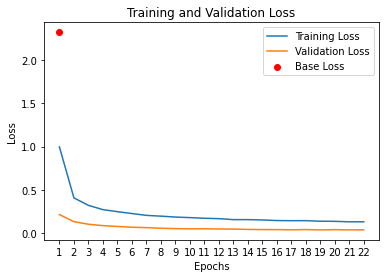

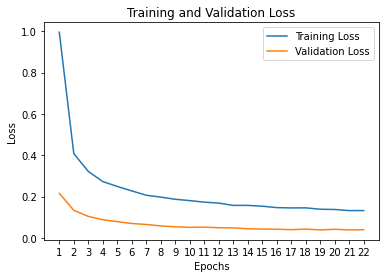

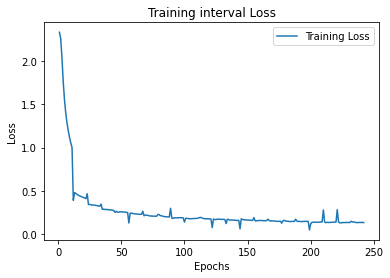

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


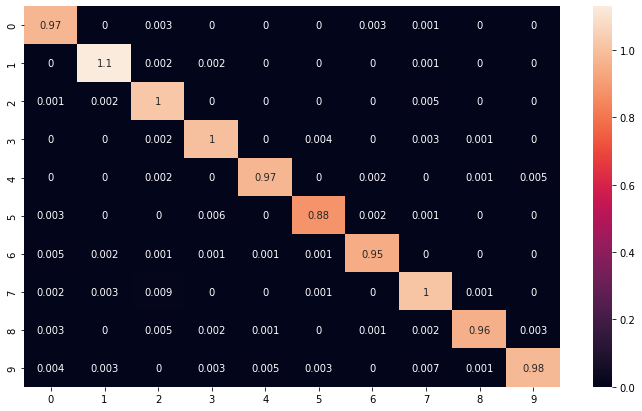

In [ ]:
import matplotlib.pyplot as plt
from numpy import arange
# plot data
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


def plot_data(train_loss, test_loss, base_loss=None):
    '''
    Plot train and test loss
        loss without training
    base_loss

    '''
    num_epoch = [i for i in range(1,len(train_loss)+1)]
    plt.plot(num_epoch, train_loss, label='Training Loss')
    plt.plot(num_epoch, test_loss, label='Validation Loss')
    if base_loss != None:
        plt.scatter(1, base_loss, color='red', label='Base Loss')
    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Set the tick locations
    plt.xticks(arange(1, len(train_loss)+1))
    
    # Display the plot
    plt.legend(loc='best')
    plt.show()



def plot_interval_loss(interval_loss):
    #flatten interval loss
    interval_loss=[element for sublist in interval_loss for element in sublist]
    num_intervals = [i for i in range(1,len(interval_loss)+1)]
    plt.plot(num_intervals, interval_loss, label='Training Loss')
    plt.title('Training interval Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()



def plot_confusion_matrix(test_loader=test_loader, save=False):
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
            output = network(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            #print(output)
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('0', '1', '2', '3', '4',
            '5', '6', '7', '8', '9')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    #print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    if save is True:
        plt.savefig('output.png')


def plot_accuracy(acc_tab=acc_tab):
    length = [i for i in range(len(acc_tab))]
    plt.plot(length, acc_tab, label='Accuracy')
    plt.title('Accuracy of model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show() 

def print_best(train_loss=train_loss, test_loss=test_loss, acc_tab=acc_tab):
    '''
    Dodac dla ktorej epoki najlepsze wyniki dla ktorego
    '''
    print(f"LOWEST TRAIN_LOSS: {min(train_loss)}")
    print(f"LOWEST TEST_LOSS: {min(test_loss)}")
    print(f"HIGHREST ACCURACY: {max(acc_tab)}")

print_best()
plot_data(train_loss, test_loss, base_loss)
plot_data(train_loss, test_loss)
plot_interval_loss(all_interval_losses)
plot_accuracy()
plot_confusion_matrix(test_loader)

# With scheduler

LOWEST TRAIN_LOSS: 0.16759525594919095
LOWEST TEST_LOSS: 0.05851049907505512
HIGHREST ACCURACY: 0.9827


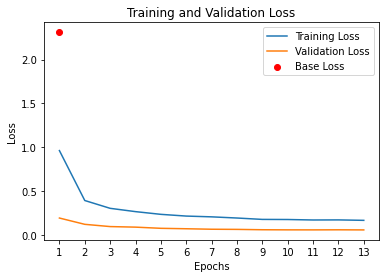

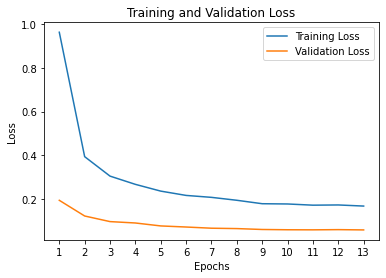

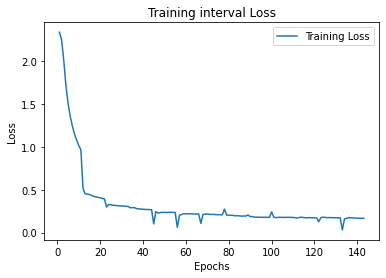

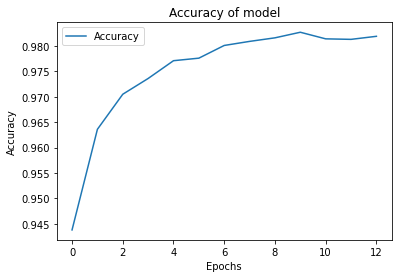

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


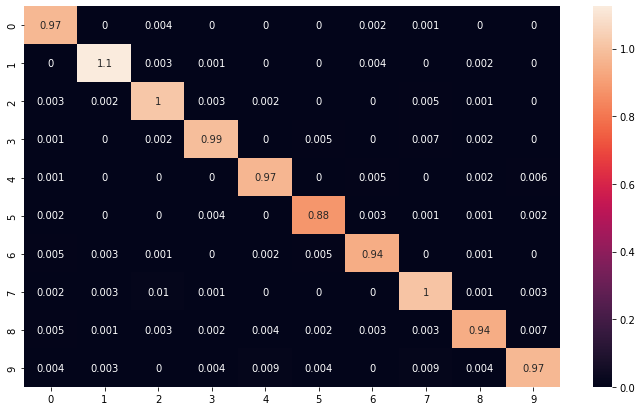

In [ ]:
print_best()
plot_data(train_loss, test_loss, base_loss)
plot_data(train_loss, test_loss)
plot_interval_loss(all_interval_losses)
plot_accuracy()
plot_confusion_matrix(test_loader)


# EDA bad examples

In [ ]:
# show missclasification with label and image


# Zamiast sprawdzac po kazdej epoce , sprawdzac po ilosci danych ktore siec widziala

In [ ]:
# plot data

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


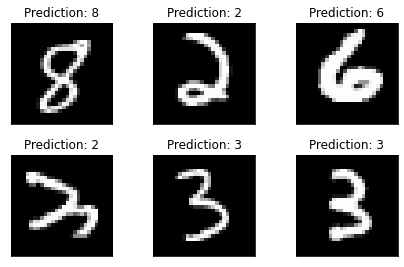

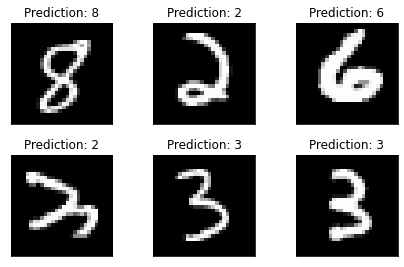

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
# kontynuowanie z checkpointu